##

### Info

-  

Table of content:
- 


### Setup

In [ ]:
import os
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zillow.dataclasses.data_wrangling import WranglingColumnsConfig
from zillow.config.feature_engineering import FeaturesDtypeConversionConfig_v1
from zillow.analysis.data_wrangling import find_adv_missing_per_col, find_missing_corrs_per_col, split_rp_from_miss_corr_df, plot_miss_corrs
from zillow.utils.common import read_data, find_shared_cols, find_unshared_cols, get_feat_nature_types, throw_col_not_exist_warning, modify_dataclass
from zillow.config.config import load_config_no_wrap, create_config_from_dict, merge_configs
from zillow.config.paths import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, ANALYSIS_RESULTS_DIR

cfg = load_config_no_wrap('default')
cur_cfg = create_config_from_dict({
    'load_all_data': False,
    'main_train_path': INTERIM_DATA_DIR / 'cleaned_train_2016_v1.0.parquet',
})
cfg = merge_configs(cfg, cur_cfg)

np.random.seed(cfg.RSEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

zillow_dictionary = pd.read_csv(RAW_DATA_DIR / "zillow_data_dictionary.csv")

if cfg.to_load_all_data:
    properties_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2016_v1.0.parquet", dtype='default')
    properties_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2017_v1.0.parquet", dtype='default')
    train_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2016_v1.0.parquet", dtype='default')
    train_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2017_v1.0.parquet", dtype='default')

train = read_data(cfg.main_train_path, dtype='default')

wrangling_cols = WranglingColumnsConfig()
features_dtype_cfg = FeaturesDtypeConversionConfig_v1()


### Utils

In [2]:
def select_important_missing_cols(df, lgst_clas=None, lgbm_clas=None, miss_corrs=None):
    missing_cols = df.columns[df.isna().any(axis=0)]
    unimportant_cols = set()

    if lgst_clas is not None:
        unimportant_cols |= (set(lgst_clas[lgst_clas['mean'] < 0.6].index.to_list()))
    
    if lgbm_clas is not None:
        unimportant_cols |= (set(lgbm_clas[lgbm_clas['mean'] < 0.7].index.to_list()))
    
    if miss_corrs is not None:
        unimportant_cols |= set(find_unimportant_cols_from_miss_corrs(miss_corrs))
        
    return df[find_unshared_cols(missing_cols, unimportant_cols)]

def find_unimportant_cols_from_miss_corrs(miss_corrs: pd.DataFrame):
    significant_r = 0.15
    correlated_cols_pct = 10
    significant_pvalue = cfg.stat_significant_magnitude / miss_corrs.shape[1]
    significant_count = miss_corrs.shape[1] * correlated_cols_pct / 100

    corrs_r, corrs_p = split_rp_from_miss_corr_df(miss_corrs)
    corrs_r = corrs_r.sort_index().abs()
    corrs_p = corrs_p.sort_index().abs()

    def is_important(col):
        r_and_p = (corrs_p[col] <= significant_pvalue).values & (corrs_r[col] >= significant_r).values
        return r_and_p.sum() >= significant_count

    imp_cols = [c for c in miss_corrs.columns if is_important(c)]
    return find_unshared_cols(imp_cols, miss_corrs.columns)

In [3]:
lgst_clas = find_adv_missing_per_col(train, ANALYSIS_RESULTS_DIR, model_name='logistic')
lgbm_clas = find_adv_missing_per_col(train, ANALYSIS_RESULTS_DIR, model_name='lgbm')
miss_corrs = find_missing_corrs_per_col(train.drop(columns=cfg.index_col), ANALYSIS_RESULTS_DIR)

File already exists. Loading it...
File already exists. Loading it...
File already exists. Loading it...


### Inspection

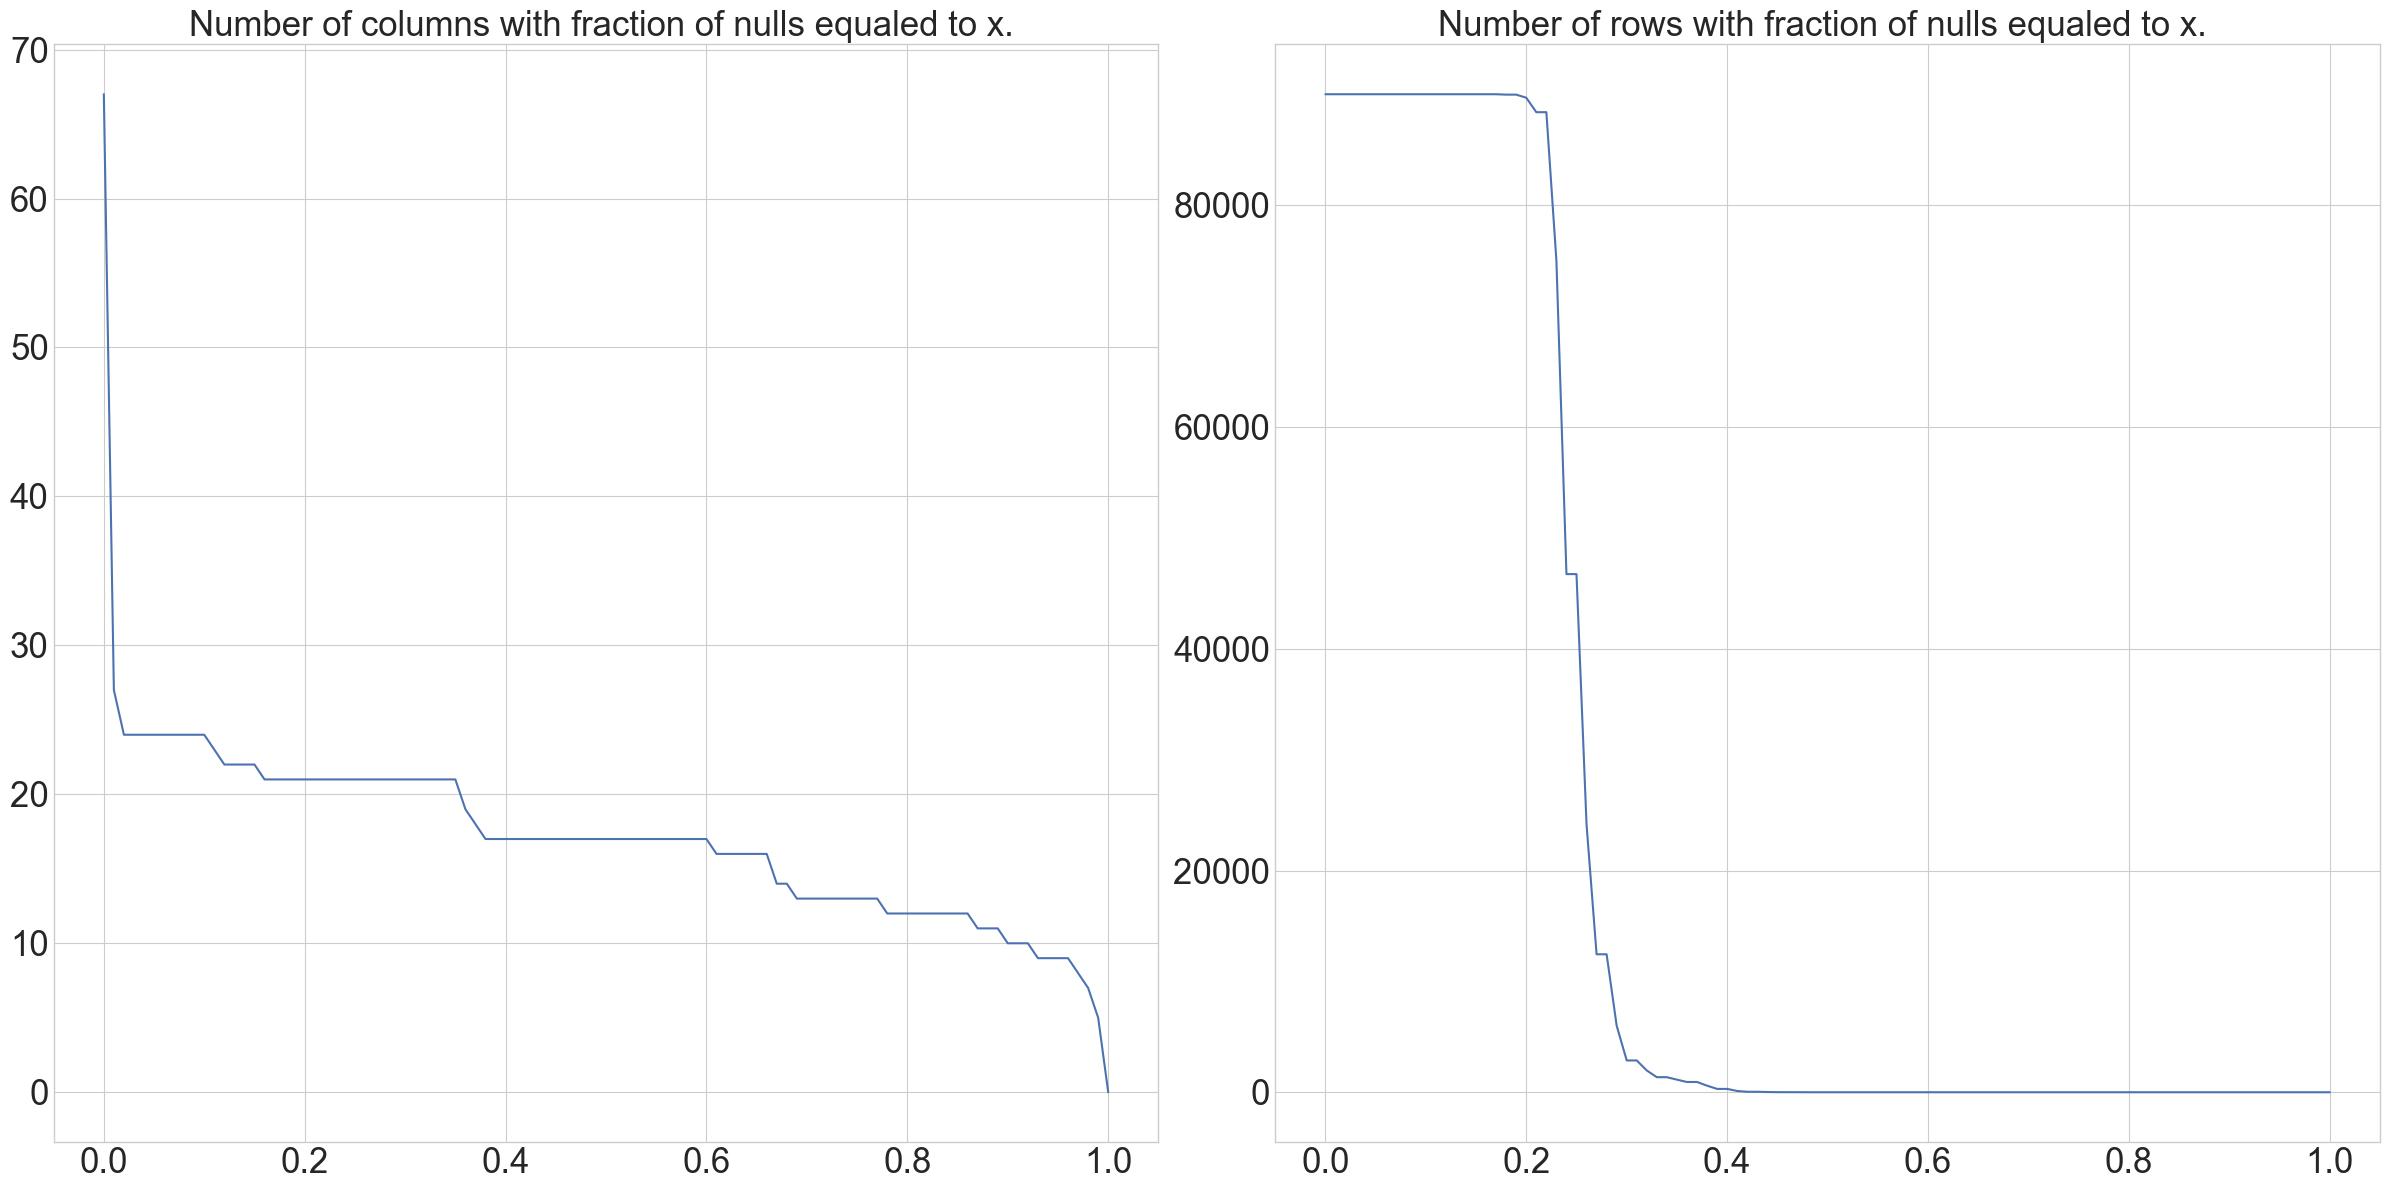

In [5]:
# Transposing data to change axises.
null_frac_cols = train.isnull().mean()
null_frac_rows = train.T.isnull().mean()
nrows_per_null_frac = np.zeros(101)
ncols_per_null_frac = np.zeros(101)
fractions = np.linspace(0, 100, num=101, endpoint=True)

# From 0 to 100 in order to avoid trailing digits in the floats. 
for i, value in enumerate(fractions):
    value /= 100 
    nrows_per_null_frac[i] = null_frac_rows[null_frac_rows >= value].index.shape[0]
    ncols_per_null_frac[i] = null_frac_cols[null_frac_cols >= value].index.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
data = [['columns', ncols_per_null_frac], ['rows', nrows_per_null_frac]]

for i, (ax, (lbl, y)) in enumerate(zip(axes, data)):
    sns.lineplot(y=y, x=fractions / 100, ax=axes[i]);
    ax.tick_params(axis='both', labelsize=25)
    ax.set_title(f"Number of {lbl} with fraction of nulls equaled to x. ", fontsize=25)

plt.tight_layout()

**Conclusions**:
1. The columns with nulls are stable. We can divide features into groups with large missingness and none missingness. These groups will be approximately of the same size. 
2. There is a sharp decrease on the rows plot. The cause is the missingness nature of columns (p. 1).
3. Some rows are completely missing indicating some erroneous samples. 

#### Correlations analysis

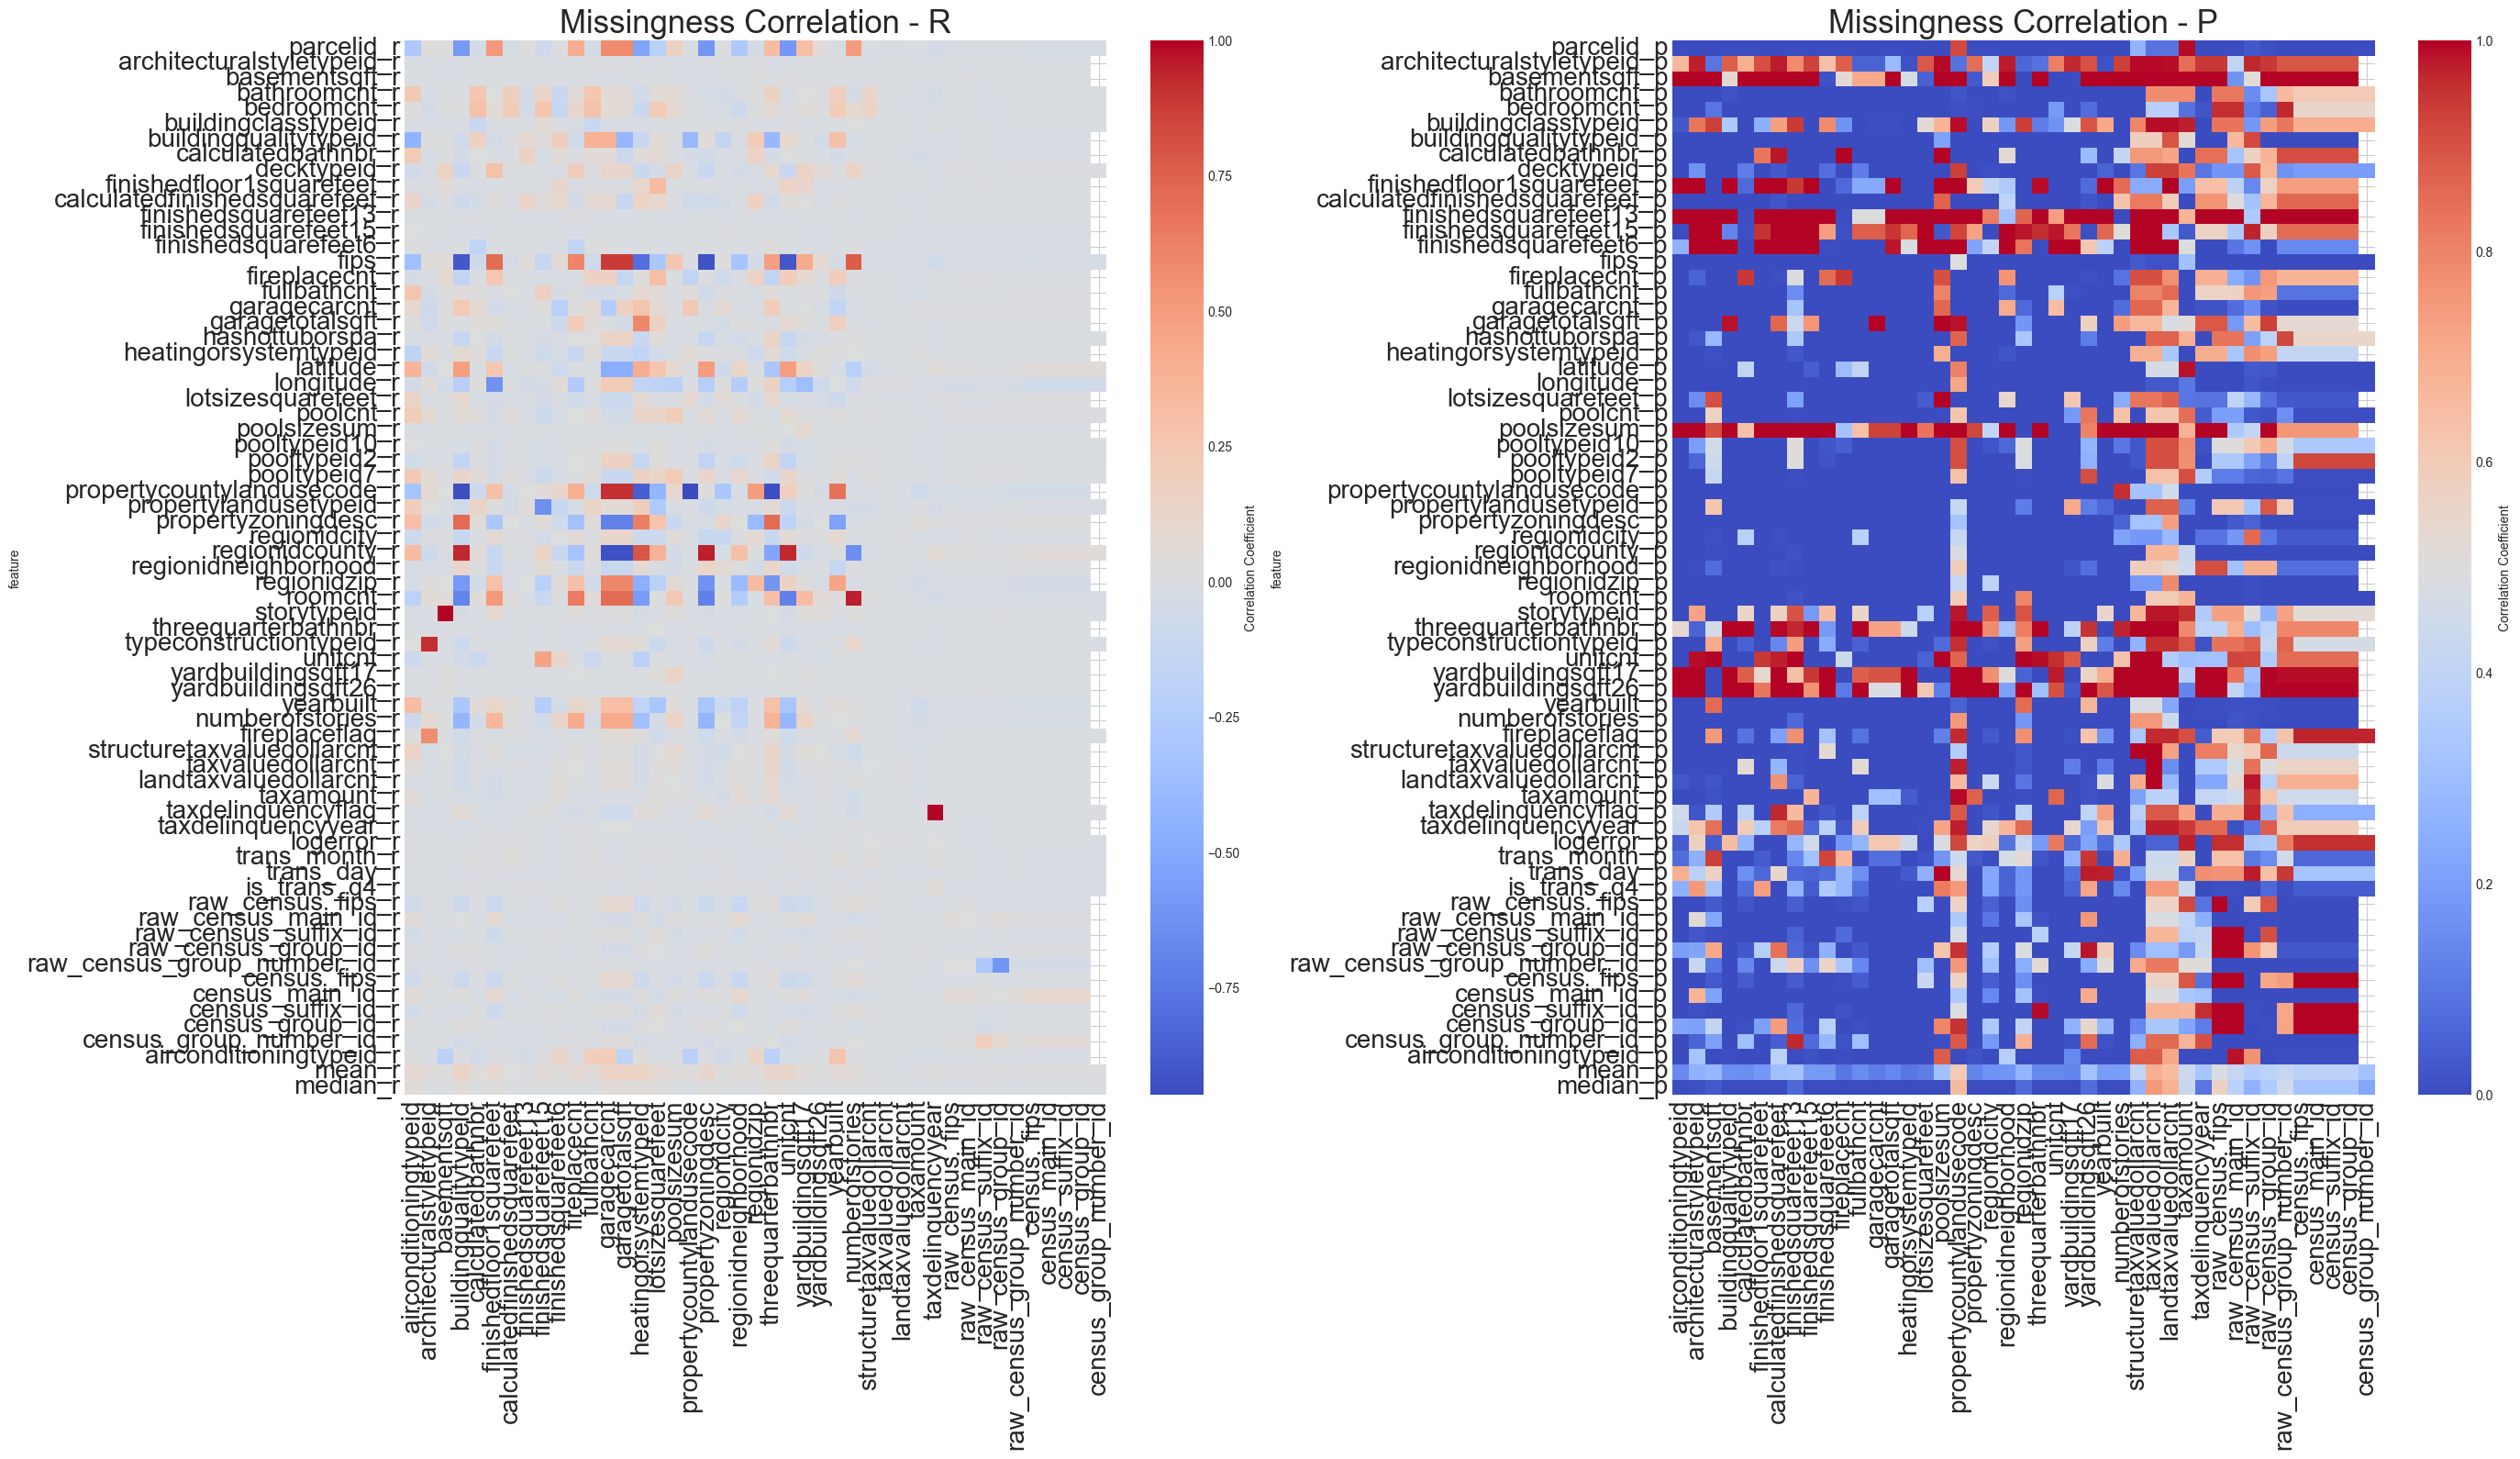

In [28]:
plot_miss_corrs(miss_corrs)

(19,)


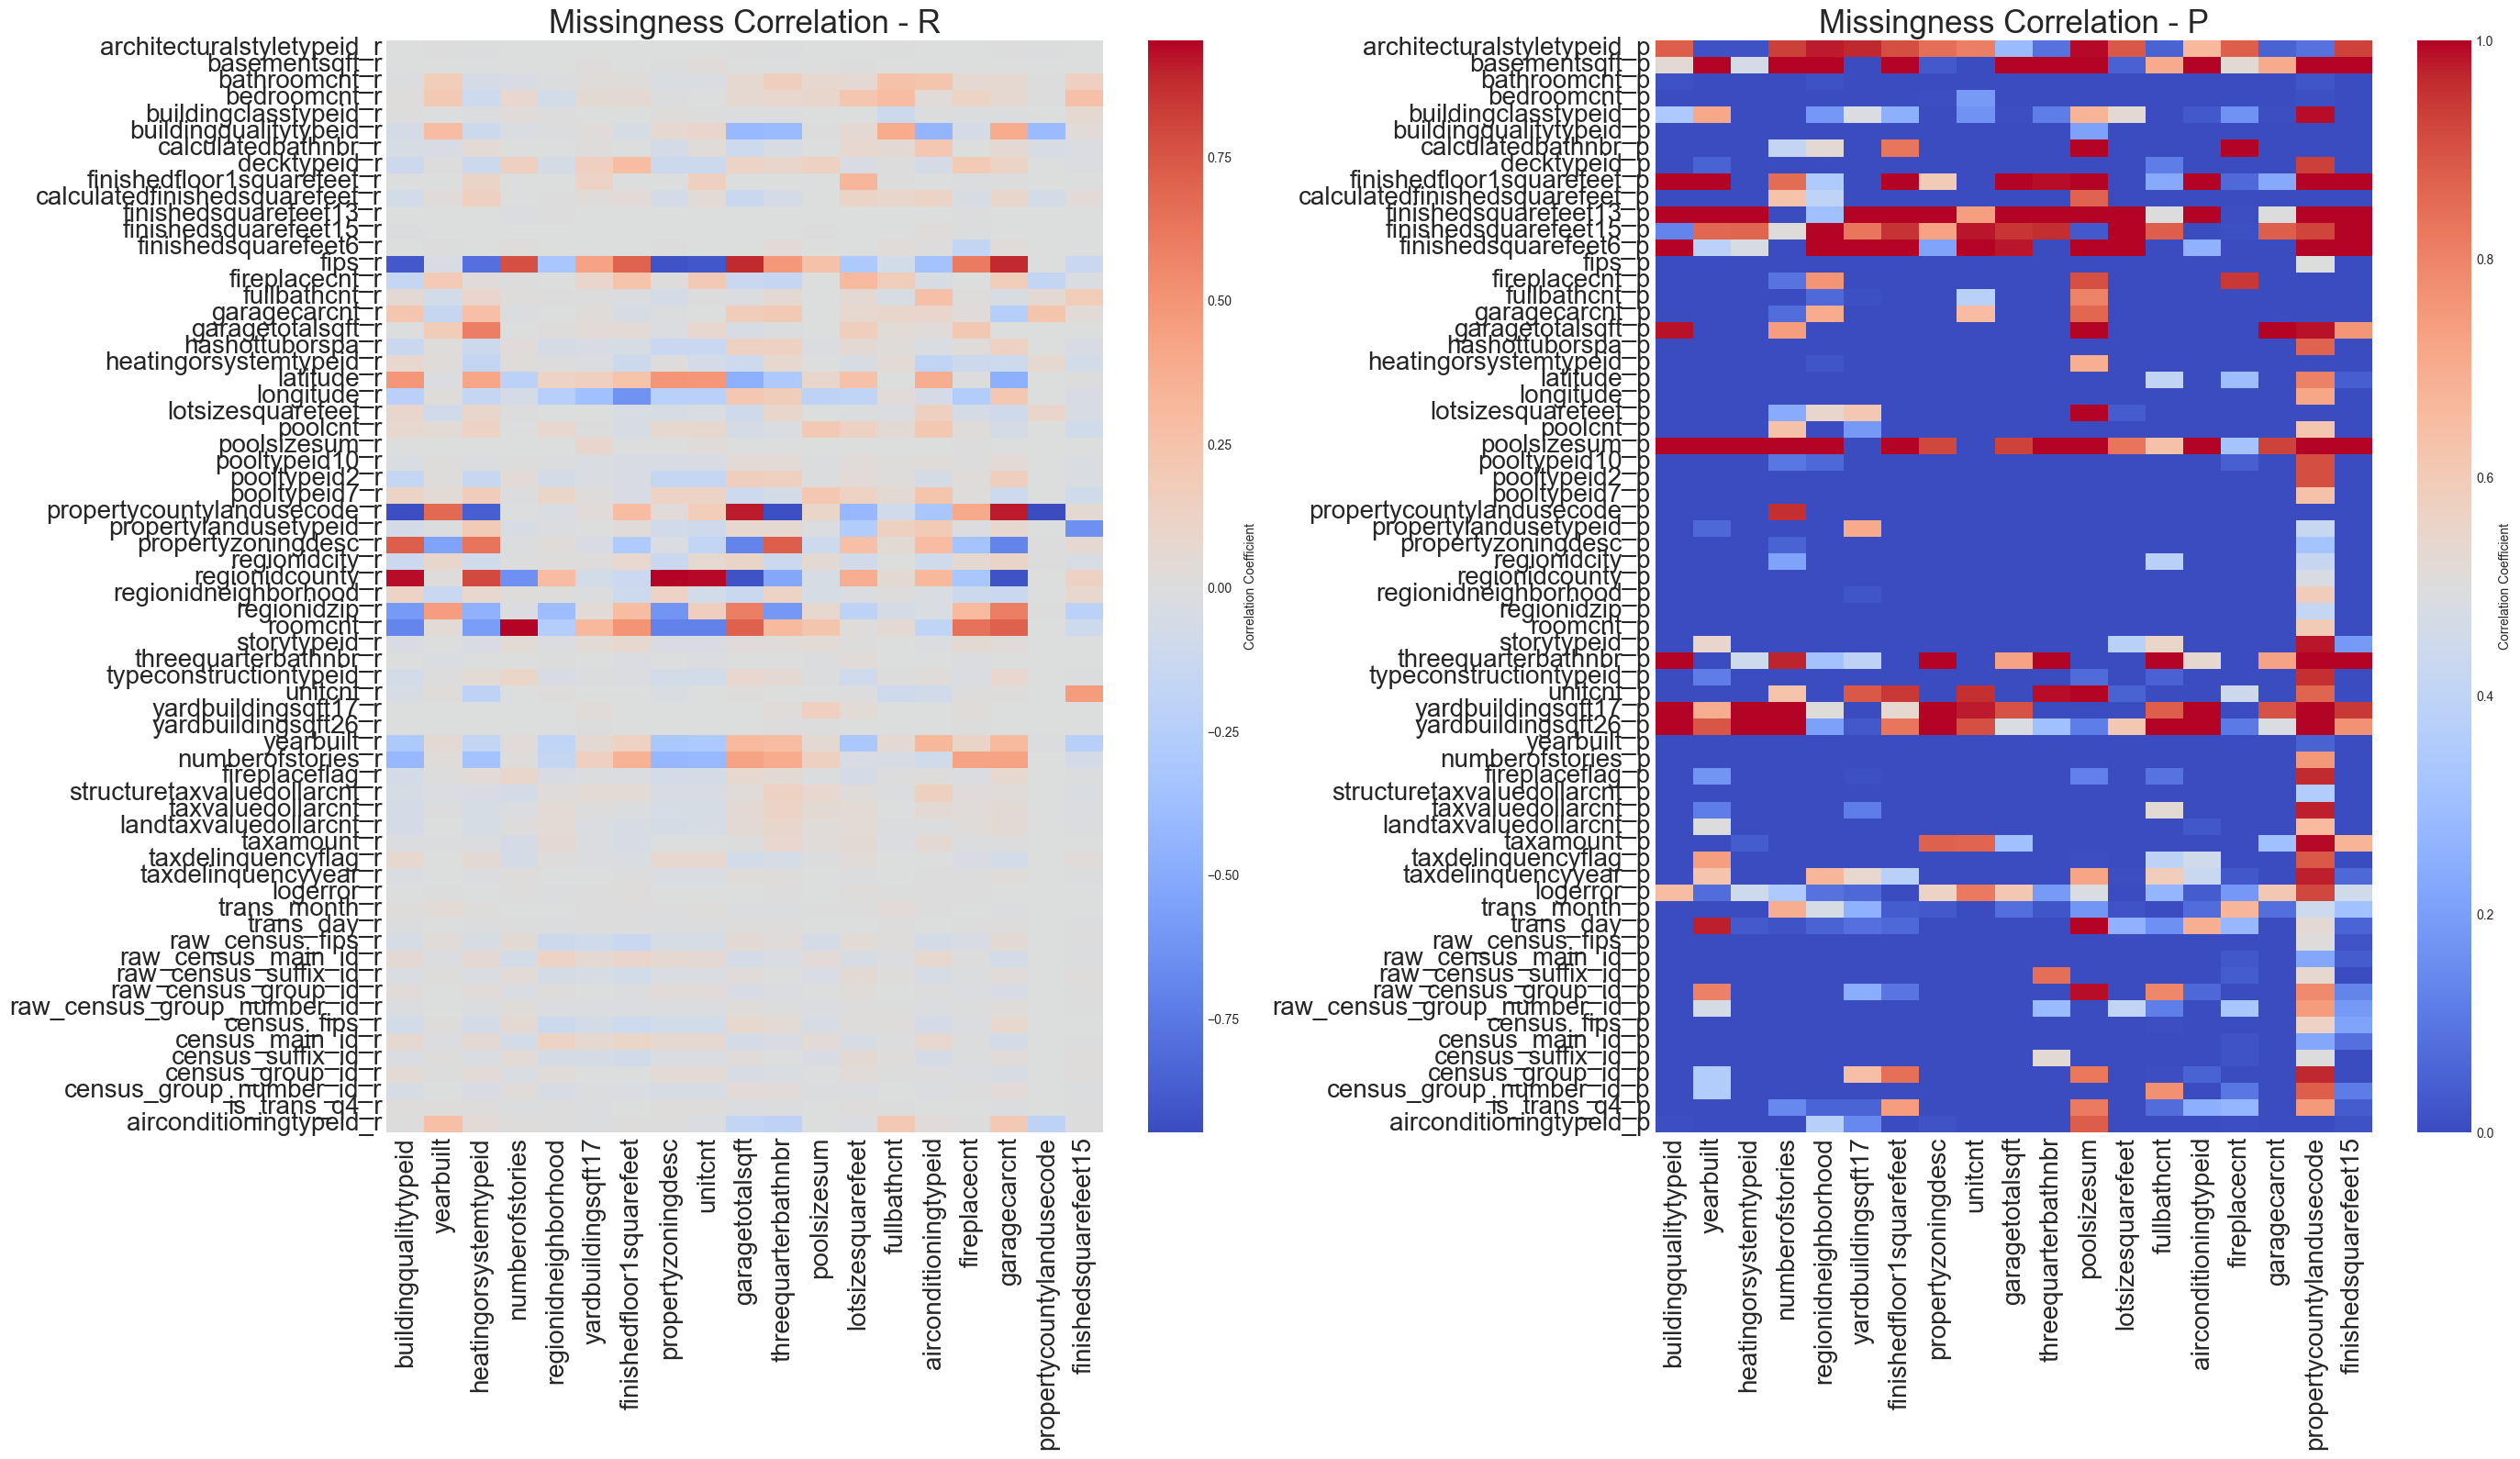

In [87]:
miss_selected_train = select_important_missing_cols(train, lgst_clas, lgbm_clas, miss_corrs)
miss_selected_cols = miss_selected_train.columns
print(miss_selected_train.columns.shape)
plot_miss_corrs(miss_corrs=miss_corrs[miss_selected_cols])

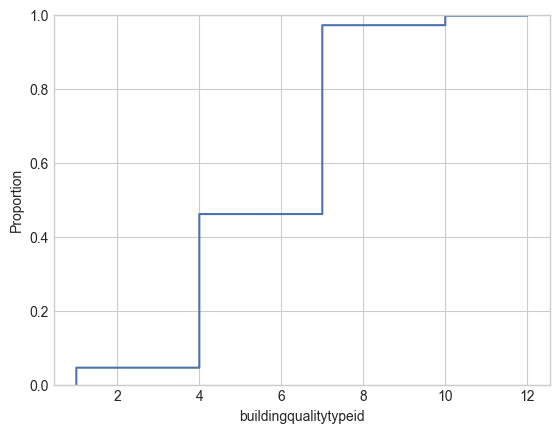

In [88]:
sns.ecdfplot(train['buildingqualitytypeid'].abs().sort_values());

In [97]:
small = null_frac_cols[null_frac_cols.between(0, 0.05, inclusive='right')].index
moderate = null_frac_cols[null_frac_cols.between(0.05, 0.3, inclusive='right')].index
large = null_frac_cols[null_frac_cols.between(0.3, 0.9, inclusive='right')].index
extreme = null_frac_cols[null_frac_cols.gt(0.9)].index

group_cols_by_missing_ratio = [small, moderate, large, extreme]